In [1]:
import os
import requests
import urllib.request
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
import chart_studio.plotly as ply
from chart_studio.plotly import plot_mpl
import plotly.express as px
from plotly.offline import plot
import plotly.io as pio
pio.renderers.default='browser'
from bcb import sgs





In [3]:

serie = 21033
df = sgs.get(serie)
df = df.loc[:"2025-01-01"]
fig = px.line(df, x=df.index, y="21033", title='Séries Temporais')
fig.show()

C:\Users\dougl\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [5]:
df = df.loc[:"2025-01-01"]

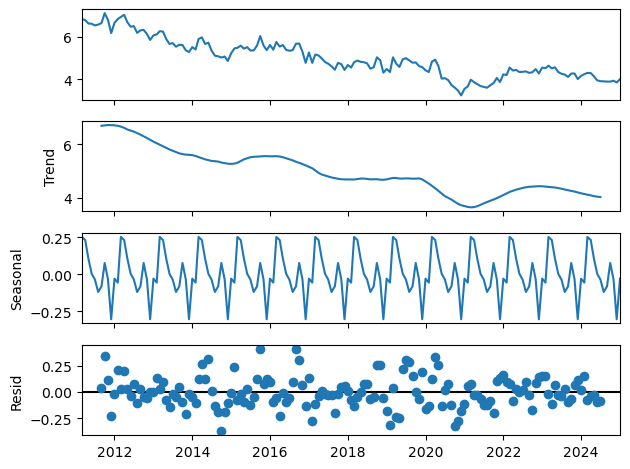

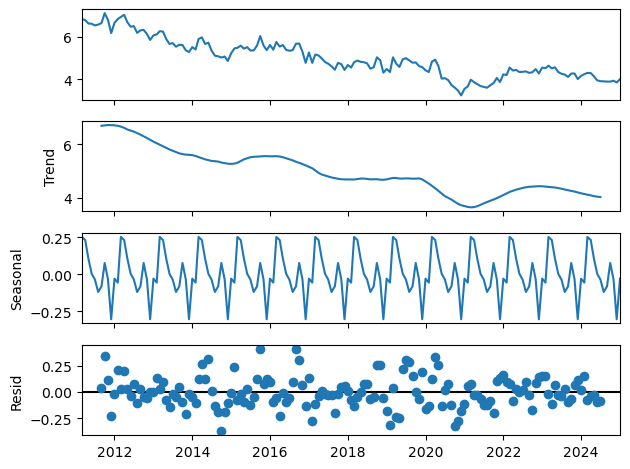

In [9]:
# Decomposição da Série
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model="add")
fig = result.plot()
result.plot()
plt.show()


In [15]:
# Teste de Estacionariedade

from statsmodels.tsa.stattools import adfuller

teste_adf = adfuller(df)
 
print('Augmneted Dickey_fuller Statistic: %f' % teste_adf[0])
print('p-value: %f' % teste_adf[1])

Augmneted Dickey_fuller Statistic: -0.685342
p-value: 0.850510


In [19]:
# Teste da primeira diferenciação
teste_adf = adfuller(df.diff().dropna())
print('Augmneted Dickey_fuller Statistic: %f' % teste_adf[0])
print('p-value: %f' % teste_adf[1])

# Primeira diferenciação induziu a estacionariedade

Augmneted Dickey_fuller Statistic: -3.641077
p-value: 0.005023


# Arima e Sarima

In [61]:
from pmdarima.arima import auto_arima

#CRIAÇÃO DE FUNÇÃO PARA FORECAST MÓVEL

def forecast_movel(treino, min_treino, horizonte, sazonalidade):
    analise = pd.DataFrame()
    for i in range(len(treino) - min_treino - horizonte):
        splt_treino =  treino[:min_treino+i]
        splt_val = treino[min_treino+i:min_treino+i+horizonte]
        stepwise_model = auto_arima(splt_treino, start_p=1, start_q=1,
                                   max_p=5, max_q=5, m=12,
                                   start_P=0, seasonal=sazonalidade,
                                   trace=True,
                                   error_action='ignore',  
                                   suppress_warnings=True, 
                                   stepwise=True)
        stepwise_model.fit(splt_treino)
        modelo = pd.DataFrame()
        modelo["Previsão"] = stepwise_model.predict(n_periods=horizonte)
        modelo["Data"] = modelo.index
        modelo["Horizonte_prj"] = modelo.reset_index().index +1
        modelo["Realizado"] = splt_val
        modelof = modelo[modelo["Horizonte_prj"].isin([horizonte])]
        analise = pd.concat([analise,modelof])
    analise["Erro"] = analise["Previsão"] -  analise["Realizado"] 
    analise["Erro Absoluto"] = abs(analise["Erro"])
    analise["Erro Quadratico"] = (analise["Erro"])**2
    analise["Erro Percentual"] = (analise["Erro"]/analise["Realizado"])*100 
    analise["Erro Percentual Absoluto"] = abs(analise["Erro Percentual"])
    return analise
    



In [65]:
tste = pd.concat([aval_filtrada,aval_filtrada], axis=0)
tste

,Previsão,Data,Realizado,Erro,Erro Absoluto,Erro Quadratico,Erro Percentual,Erro Percentual Absoluto
Horizonte_prj,,,,,,,,
6,4.569025,2019-09-16 03:17:25.161290240,4.60629,-0.037265,0.324346,0.161061,-0.496429,7.158091
6,4.569025,2019-09-16 03:17:25.161290240,4.60629,-0.037265,0.324346,0.161061,-0.496429,7.158091


## ARIMA

In [123]:
hrztes = [1,3,6,12,18]
fc_arima = pd.DataFrame()
res_total = pd.DataFrame()
res_covid = pd.DataFrame()
for x in hrztes :
    horizonte = x
    avaliacao = forecast_movel(df, 36, horizonte,False)
    aval_filtrada = avaliacao.groupby(["Horizonte_prj"]).mean()
    aval_filtrada["RMSE"] = aval_filtrada["Erro Quadratico"]**(1/2)
    aval_covid= avaliacao.loc[:"2019-12-01"].groupby(["Horizonte_prj"]).mean()
    aval_covid["RMSE"] = aval_covid["Erro Quadratico"]**(1/2)
    tst = pd.DataFrame()
    tst[f'horizonte-{horizonte}'] = avaliacao["Previsão"]
    fc_arima = pd.concat([fc_arima,tst],axis=1)
    res_total=pd.concat([res_total,aval_filtrada],axis=0)
    res_covid=pd.concat([res_covid,aval_covid],axis=0)


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.736, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.111, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.555, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.612, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.341 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.242, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.009, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.608, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.667, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.440 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.403, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.315, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.214, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.757, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.785, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.642, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.354, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.415, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.885, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.684, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.329, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.451, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.312 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.868, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.590, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.232, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.819, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.344 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.545, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.437, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.313, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.802, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.480 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.500, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.387, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.263, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.801, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.435, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.318, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.193, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.174, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.506 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.503, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.375, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.243, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.191, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.478 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.073, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.772, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.607, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.454, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.392 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.819, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.496, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.189, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.161, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.320 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.007, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.934, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.865, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.261, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.400 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.003, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.945, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.902, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.303, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.362 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.566, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.793, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.163, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.130, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.196, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.319 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.654, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.283, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.237, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.921, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.322 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.595, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.674, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.730, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.935, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.359 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.385, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.486, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.554, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.563, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.391 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.508, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.619, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.693, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.697, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.392 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.461, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.555, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.625, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.886, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.494 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.825, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.673, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.673, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.109, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.238 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.873, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.641, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.462, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.633, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.396 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.511, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.438, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.370, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.814, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.366 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.708, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.555, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.378, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.829, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.363 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.354, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.093, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.833, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.010, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.384 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.205, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.911, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.453, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.086, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.253, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.234 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.251, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.516, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.828, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.335, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.001, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.314 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.571, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.615, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.857, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.349, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.954, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.244 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.237, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.345, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.509, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.983, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.054, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.362, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.287, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.318, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.624, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.682, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1.460, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-0.168, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=0.432, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=0.540, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.798, Time=0.06 sec
 ARIMA

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.390, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.716, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.461, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.051, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.081, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.797, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.877, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.479, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.536, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.071, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2.555, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.134, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-0.699, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-0.555, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.792, Time=0.10 sec

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.519, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.745, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.585, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.119, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.136, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.961, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.050, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.643, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1.710, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.357, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.648, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.216, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.645, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.649, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.922, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.567, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.929, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.312, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.189, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.555, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.222, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.292, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.814, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.983, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.633, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.238, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.592, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.371, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.277, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.559, Time=0.11 sec

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.512, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.997, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.712, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.153, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.629, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.360 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.903, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.546, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.718, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.113, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.912, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.809, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.997, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.746, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1.828, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.128, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.674, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.949 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.755, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.572, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.434, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.816, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.362 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.621, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.278, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.427, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.537, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.858, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.195, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.986, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.262, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.075, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.950, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.810, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.920 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.366, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.829, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.019, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.866, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.777, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7.258, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.243, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.918, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.405, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.998, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.985, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.123 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.778, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.639, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.871, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.489, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.239, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7.736, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.742, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6.979, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.264, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9.618, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.154, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.566 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.736, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.728, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.984, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.613, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.358, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.697, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.703, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.986, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.288, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.565, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.184, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.325 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.904, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.014, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.253, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.772, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.749, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.854, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.859, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.991, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.350, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.861, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.550, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.258 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.401, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.410, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.737, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.285, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.281, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.327, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.460, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.858, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.230, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.304, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.406 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.604, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.508, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.859, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.471, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.448, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.521, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.534, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.653, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.028, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.366, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.683, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.294 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.025, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.686, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.040, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.718, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.735, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.951, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.963, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.097, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.282, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.754, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.276, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.418 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.798, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.998, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.406, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.171, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.198, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.723, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.930, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.798, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.691, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.459, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.199, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.148 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.776, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.036, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.204, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.715, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.914, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.709, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.911, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.858, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.311, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.924, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.108, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.076 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.698, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.088, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.217, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.746, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.017, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.635, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.645, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.784, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.291, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.854, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.114, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.187 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.701, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.088, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.271, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.607, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.253, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.541, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.559, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.352, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.916, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.197, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.401, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.418 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.253, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.221, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.035, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.189, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.161, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.166, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.171, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.993, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.573, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.053, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.818, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.247 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.750, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.388, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.048, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.167, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.433, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.176, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.182, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.012, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.627, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.066, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.986, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.106 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.556, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.682, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.181, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.375, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.499, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.430, Time=0.79 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.431, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.577, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.145, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.369, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.855, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.827 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.100, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.877, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.593, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.954, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.630, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.893, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.894, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.077, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.510, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2.893, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.095, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.253 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.171, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.905, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.563, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.906, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.704, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.173, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.173, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.887, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.465, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.827, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.031, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.264 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.218, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.898, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.518, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.159, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.714, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.869, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.910, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.396, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.781, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.046, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.368 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.344, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.892, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.472, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.226, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.748, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.251, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.031, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.332, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.344, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.104, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.140 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.801, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.754, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.374, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.304, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.817, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.553, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.336, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.238, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.801, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.968, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.065 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.898, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.854, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.663, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.389, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.139, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.905, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.458, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.838, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1.898, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.064, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.364 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.361, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.051, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.949, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.069, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.656, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.458, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.454, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.645, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.250, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.545, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.582, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.014 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.464, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.253, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.915, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.046, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.947, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.572, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.566, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.741, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.184, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.334, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.645, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.255 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.286, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.654, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.866, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.367, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.768, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.362, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.321, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.202, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.533, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.140, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.837, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.161 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.188, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.323, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.020, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.343, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.287, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.484, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.431, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.193, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.596, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.280, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.973, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.290 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.951, Time=0.06 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.571, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.119, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.534, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.650, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.096, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.115, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.455, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.127, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.690, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.406, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.156 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.762, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.064, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.212, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.282, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.456, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.631, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.673, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.528, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.916, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.955 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.475, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.072, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.398, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.245, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.769, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.729, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.776, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.606, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.430, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.529, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.337, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.521 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.424, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.019, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.564, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.222, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.563, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.756, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.774, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.657, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.465, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.244 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.590, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.764, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.097, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.374, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.315, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.355, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.368, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.761, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.990, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.178, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.442, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.656 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.296, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.941, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.514, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.057, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.463, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.948, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.970, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.348, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.333, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.877, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.769, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.192 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.293, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.138, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.637, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.071, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.718, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.955, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.981, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.379, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.343, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.982, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.768, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.998 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.242, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.352, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.867, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.221, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.999, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.899, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.925, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.337, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.502, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.926, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.881, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.158 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.241, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.444, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.902, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.217, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.084, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.883, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.911, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.298, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.493, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.911, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.855, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.302 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.413, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.869, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.269, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.606, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.617, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.111, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.130, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.604, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.924, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.131, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.389, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.412 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.620, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.943, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.345, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.723, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.726, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.089, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.104, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.390, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.961, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.103, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.560, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.146 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.266, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.261, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.657, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.156, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.148, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.522, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.530, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.831, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.410, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2.526, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.277, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.097 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.094, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.360, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.777, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.369, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.306, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.265, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.265, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.577, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.529, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.590, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.712, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.115 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.400, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.631, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.991, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.109, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.219, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.061, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.077, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.583, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.395, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.930, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.588, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.429 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.239, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.885, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.752, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.513, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.420, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.729, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.761, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.322, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.218, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.760, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.106, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.003 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.417, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.215, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.906, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.024, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.923, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.981, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.001, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.561, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.116, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3.000, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.106, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.219 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.080, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.354, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.181, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.787, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.437, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.005, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.170, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.736, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.185, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.139, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.343, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.289 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.428, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.483, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.291, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.406, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.551, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.235, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.414, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.133, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.451, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.376, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.893, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.203 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.932, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.638, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.405, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.687, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.776, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.248, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.357, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.373, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.732, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.014, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.745, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.674 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.374, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.204, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.680, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.692, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.186, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.362, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.582, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.362, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.050, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.301 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.587, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.512, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.161, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.007, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.229, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.478, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.645, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.477, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.085, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.358 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.196, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.856, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.817, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.607, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.399, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.669, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.704, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.298, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.337, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.704, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.880, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.140 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.269, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.563, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.636, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.624, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.313, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.571, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.626, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.978, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.690, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.624, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.919, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.511 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.467, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.221, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.859, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.907, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.702, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.228, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.336, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.228, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.620, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.995 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.847, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.836, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.866, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.651, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.179, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.305, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.325, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.893, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.099, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.272, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.543, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.428 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.804, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.099, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.367, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.873, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.982, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.981, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.895, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8.161, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.433 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.020, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.177, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.399, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.179, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.986, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.601, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.577, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.965, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8.839, Time=0.08 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.449 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.150, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.321, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.490, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.380, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.996, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.941, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.015, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.198, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.508 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.273, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.444, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.617, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.575, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.990, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.374, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.897, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.684, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.365, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.319 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.323, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.477, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.647, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.659, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.947, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.316, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2.843, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.608, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.428, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.300 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.365, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.498, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.657, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.734, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.907, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.255, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.785, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.383, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.502, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.405 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.747, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.853, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.983, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.013, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.172, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.058, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.557, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.627, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.406 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.030, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.219, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.413, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.214, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.478, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.414, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.278, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.790, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.483 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.204, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.564, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.972, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.199, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.474, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.302, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.241, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4.171, Time=0.29 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2.274, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5.589, Time=0.10 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 3

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.734, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.697, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.851, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.115, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.828, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.546, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.956, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.539, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.546 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.144, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.013, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.320, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.001, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.959, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2.866, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.688, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5.861, Time=0.38 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3.958, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=6.402, Time=0.11 sec

Best model:  ARIMA(1,

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.621, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.173, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.058, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.415, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.051, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.037, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.663, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.947, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.683 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.457, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.353, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.970, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.106, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.974, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.705, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.837, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.613, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.010, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.176 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.736, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.431, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.985, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.465, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.938, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.694, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.816, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5.594, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.031, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.255 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.799, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.445, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.002, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.510, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.189, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.099, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.072, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.900, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.128, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3.210, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3.554, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3.419, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.823, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4.414, Time=0.08 sec
 ARIMA(2,1,1)(

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.929, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.533, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.075, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.700, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.000, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.193, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.015, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.892, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.857, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.444 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.953, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.522, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.051, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.718, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.163, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.021, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.992, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.843, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.198, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.360 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.703, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.981, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.532, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.047, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.734, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.034, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.874, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.965, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.831, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.220, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.862 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.639, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.024, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.540, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.039, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.819, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.035, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.918, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.948, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.780, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.208, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.799 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.242, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.053, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.532, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.982, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.830, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.054, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.956, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.072, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.266, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.264, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.792 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.945, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.524, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.035, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.476, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.208, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.523, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.495, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.616, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.796, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.922, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.719 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.150, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.517, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.118, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.043, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.188, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.230, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3.278, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.404, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.064, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.266 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.621, Time=0.09 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.667, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.301, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.944, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.301, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.687, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.692, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2.773, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.891, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.864, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.780, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2.493, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-2.641, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4.284, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1.392, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2.

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.566, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.650, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.960, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.699, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.747, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.761, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3.823, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.940, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.938, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3.821, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3.571, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-3.717, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5.356, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6.072, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.053, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.060, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3.631, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.469, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4.212, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5.179, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2.426, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2.516, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.052, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.580 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.125, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.853, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.966, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4.586, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.199, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5.262, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6.195, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.349, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3.575, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.999, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.496 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.096, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.813, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.992, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5.623, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.187, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.226, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.177, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.361, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4.724, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.045, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.592 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.629, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.115, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4.381, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.016, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.366, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6.765, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.734, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.559, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.659, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5.081, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.324, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.360 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.462, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.089, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.282, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.879, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.292, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7.734, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7.704, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8.488, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7.888, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6.012, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8.496, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7.530, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7.308, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-7.560, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9.148, Time=0.13 s

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.132, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.341, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7.926, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.309, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8.784, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8.757, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9.490, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6.614, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7.816, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10.117, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8.525, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7.206, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8.311, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8.263, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-9.416, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : A

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10.619, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.035, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.256, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8.820, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.143, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9.602, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9.580, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10.307, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7.510, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8.582, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10.802, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9.321, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.034, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8.974, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8.933, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             :

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12.283, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.524, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.855, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9.480, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.737, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10.396, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10.372, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11.076, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8.146, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9.637, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-11.689, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.666 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13.409, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.585, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.909, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10.532, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.798, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11.527, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11.502, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12.191, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.227, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9.781, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.810, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.710 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13.491, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.580, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.926, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10.636, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.631, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11.604, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12.427, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.439, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10.668, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.628, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.976 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14.359, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7.134, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9.722, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11.509, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.286, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-12.455, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13.278, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10.262, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10.695, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13.587, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.459 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15.311, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.035, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10.528, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12.329, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9.239, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12.958, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13.426, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14.255, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11.200, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11.787, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14.610, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.512 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16.261, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.008, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.474, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13.231, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.248, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14.372, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-15.129, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12.063, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12.604, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-15.641, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.863 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17.385, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.093, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.582, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14.339, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.328, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-15.493, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16.235, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.175, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13.720, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16.781, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.903 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18.327, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.852, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.365, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15.162, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.995, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16.445, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-17.179, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14.017, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14.689, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-17.558, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.608 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17.581, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.389, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.757, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15.494, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12.410, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16.955, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-17.621, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-17.060, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-15.230, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-17.170, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.599 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18.699, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.480, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.835, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16.536, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.474, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-18.027, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-18.644, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15.441, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16.323, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-18.762, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-16.839, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-15.456, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-17.022, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16.961, 

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.969, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17.679, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.572, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-19.178, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-19.778, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16.585, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-18.070, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-19.853, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.736 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22.226, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.696, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.107, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18.829, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.676, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-20.353, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-20.949, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17.740, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-18.648, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-20.977, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.790 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-23.417, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15.808, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18.245, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-19.978, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16.788, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-21.544, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-22.131, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-18.894, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-20.751, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-22.134, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.206 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24.568, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.868, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19.323, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21.063, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17.876, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22.695, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-23.253, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-19.984, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-21.277, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-23.300, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.281 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.736, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.111, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.555, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.612, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.242, Time=0.02 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.009, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.608, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.667, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.255 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.403, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.315, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.214, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.757, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.301 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.785, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.642, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.354, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.415, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.253 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.885, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.684, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.329, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.451, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.271 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.868, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.590, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.232, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.819, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.545, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.437, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.313, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.802, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.421 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.500, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.387, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.263, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.801, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.330 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.435, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.318, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.193, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.174, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.503, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.375, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.243, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.191, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.400 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.073, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.772, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.607, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.454, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.303 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.819, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.496, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.189, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.161, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.372 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.007, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.934, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.865, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.261, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.317 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.003, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.945, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.902, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.303, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.324 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.566, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.793, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.163, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.130, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.196, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.654, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.283, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.237, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.921, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.301 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.595, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.674, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.730, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.935, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.301 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.385, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.486, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.554, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.563, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.391 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.508, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.619, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.693, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.697, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.421 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.461, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.555, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.625, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.886, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.384 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.825, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.673, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.673, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.109, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.223 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.873, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.641, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.462, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.633, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.423 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.511, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.438, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.370, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.814, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.283 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.708, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.555, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.378, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.829, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.255 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.354, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.093, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.833, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.010, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.275 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.205, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.911, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.453, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.086, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.253, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.209 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.251, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.516, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.828, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.335, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.001, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.246 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.571, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.615, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.857, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.349, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.954, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.330 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.237, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.345, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.509, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.983, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.054, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.362, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.287, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.318, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.624, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.682, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1.460, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-0.168, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=0.432, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=0.540, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.798, Time=0.06 sec
 ARIMA

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.716, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.461, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.051, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.081, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.797, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.877, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.479, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.536, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.071, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2.555, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.134, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-0.699, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-0.555, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.792, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=0.808, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]       

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.519, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.745, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.585, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.119, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.136, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.961, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.050, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.643, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1.710, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.357, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.648, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.216, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.645, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.649, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.922, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.929, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.312, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.189, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.555, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.222, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.292, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.814, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.983, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.633, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.238, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.592, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.371, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.277, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.559, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=0.564, Time=0.15 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]       

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.153, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.629, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.192 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.903, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.718, Time=0.02 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.113, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.912, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.809, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.997, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.746, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1.828, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.128, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.674, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.938 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.755, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.572, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.434, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.816, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.352 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.621, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.278, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.427, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.537, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.858, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.195, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.986, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.262, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.075, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.950, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.810, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.962 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.366, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.829, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.019, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.866, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.777, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7.258, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.243, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.918, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.405, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.998, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.985, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.164 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.778, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.639, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.871, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.489, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.239, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7.736, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.742, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6.979, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.264, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9.618, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.154, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.174 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.736, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.728, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.984, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.613, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.358, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.697, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.703, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.986, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.288, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.565, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.184, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.059 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.904, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.014, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.253, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.772, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.749, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.854, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.859, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.991, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.350, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.861, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.550, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.303 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.401, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.410, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.737, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.285, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.281, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.327, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.460, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.858, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.230, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.304, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.232 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.604, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.508, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.859, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.471, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.448, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.521, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.534, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.653, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.028, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.366, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.683, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.213 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.025, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.686, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.040, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.718, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.735, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.951, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.963, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.097, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.282, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.754, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.276, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.159 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.798, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.998, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.406, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.171, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.198, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.723, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.930, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.798, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.691, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.459, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.199, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.020 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.776, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.036, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.204, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.715, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.914, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.709, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.911, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.858, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.311, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.924, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.108, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.043 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.698, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.088, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.217, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.746, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.017, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.635, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.645, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.784, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.291, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.854, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.114, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.004 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.701, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.088, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.271, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.607, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.253, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.541, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.559, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.352, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.916, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.197, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.401, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.086 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.253, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.221, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.035, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.189, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.161, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.166, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.171, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.993, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.573, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.053, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.818, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.932 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.750, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.388, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.048, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.167, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.433, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.176, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.182, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.012, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.627, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.066, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.986, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.049 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.556, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.682, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.181, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.375, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.499, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.430, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.431, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.577, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.145, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.369, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.855, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.165 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.100, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.877, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.593, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.954, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.630, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.893, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.894, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.077, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.510, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2.893, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.095, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.982 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.171, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.905, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.563, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.906, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.704, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.173, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.173, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.887, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.465, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.827, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.031, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.100 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.218, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.898, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.518, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.159, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.714, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.869, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.910, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.396, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.781, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.046, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.288 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.344, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.892, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.472, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.226, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.748, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.251, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.031, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.332, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.344, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.104, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.190 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.801, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.754, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.374, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.304, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.817, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.553, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.336, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.238, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.801, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.968, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.164 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.898, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.854, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.663, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.389, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.139, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.905, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.458, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.838, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1.898, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.064, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.187 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.361, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.051, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.949, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.069, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.656, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.458, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.454, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.645, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.250, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.545, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.582, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.961 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.464, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.253, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.915, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.046, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.947, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.572, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.566, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.741, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.184, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.334, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.645, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.070 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.286, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.654, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.866, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.367, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.768, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.362, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.321, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.202, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.533, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.140, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.837, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.356 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.188, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.323, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.020, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.343, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.287, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.484, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.431, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.193, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.596, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.280, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.973, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.154 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.951, Time=0.07 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.571, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.119, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.534, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.650, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.096, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.115, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.455, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.127, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.690, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.406, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.164 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.762, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.064, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.212, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.282, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.456, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.631, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.673, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.528, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.916, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.845 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.475, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.072, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.398, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.245, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.769, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.729, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.776, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.606, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.430, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.529, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.337, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.373 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.424, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.019, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.564, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.222, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.563, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.756, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.774, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.657, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.465, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.250 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.590, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.764, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.097, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.374, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.315, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.355, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.368, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.761, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.990, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.178, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.442, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.227 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.296, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.941, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.514, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.057, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.463, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.948, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.970, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.348, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.333, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.877, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.769, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.145 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.293, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.138, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.637, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.071, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.718, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.955, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.981, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.379, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.343, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.982, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.768, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.015 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.242, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.352, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.867, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.221, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.999, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.899, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.925, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.337, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.502, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.926, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.881, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.125 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.241, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.444, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.902, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.217, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.084, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.883, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.911, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.298, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.493, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.911, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.855, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.149 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.413, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.869, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.269, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.606, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.617, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.111, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.130, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.604, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.924, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.131, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.389, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.418 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.620, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.943, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.345, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.723, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.726, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.089, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.104, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.390, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.961, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.103, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.560, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.953 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.266, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.261, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.657, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.156, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.148, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.522, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.530, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.831, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.410, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2.526, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.277, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.070 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.094, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.360, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.777, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.369, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.306, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.265, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.265, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.577, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.529, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.590, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.712, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.214 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.400, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.631, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.991, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.109, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.219, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.061, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.077, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.583, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.395, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.930, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.588, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.465 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.239, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.885, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.752, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.513, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.420, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.729, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.761, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.322, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.218, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.760, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.106, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.111 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.417, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.215, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.906, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.024, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.923, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.981, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.001, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.561, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.116, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3.000, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.106, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.082 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.080, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.354, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.181, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.787, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.437, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.005, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.170, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.736, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.185, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.139, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.343, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.207 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.428, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.483, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.291, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.406, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.551, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.235, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.414, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.133, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.451, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.376, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.893, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.341 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.932, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.638, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.405, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.687, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.776, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.248, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.357, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.373, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.732, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.014, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.745, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.238 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.374, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.204, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.680, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.692, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.186, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.362, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.582, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.362, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.050, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.001 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.587, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.512, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.161, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.007, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.229, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.478, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.645, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.477, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.085, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.441 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.196, Time=0.08 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.856, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.817, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.607, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.399, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.669, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.704, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.298, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.337, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.704, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.880, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.006 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.269, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.563, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.636, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.624, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.313, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.571, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.626, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.978, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.690, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.624, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.919, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.090 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.467, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.221, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.859, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.907, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.702, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.228, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.336, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.228, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.620, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.001 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.847, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.836, Time=0.04 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.866, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.651, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.179, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.305, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.325, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.893, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.099, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.272, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.543, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.159 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.804, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.099, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.367, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.873, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.982, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.981, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.895, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8.161, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.389 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.020, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.177, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.399, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.179, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.986, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.601, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.577, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.965, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8.839, Time=0.09 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.589 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.150, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.321, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.490, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.380, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.996, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.941, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.015, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.198, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.366 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.273, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.444, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.617, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.575, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.990, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.374, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.897, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.684, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.365, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.240 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.323, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.477, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.647, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.659, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.947, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.316, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2.843, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.608, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.428, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.375 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.365, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.498, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.657, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.734, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.907, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.255, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.785, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.383, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.502, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.373 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.747, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.853, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.983, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.013, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.172, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.058, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.557, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.627, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.478 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.030, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.219, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.413, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.214, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.478, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.414, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.278, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.790, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.447 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.204, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.564, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.972, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.199, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.474, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.302, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.241, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4.171, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2.274, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5.589, Time=0.11 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 3

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.734, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.697, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.851, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.115, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.828, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.546, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.956, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.539, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.751 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.144, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.013, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.320, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.001, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.959, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2.866, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.688, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5.861, Time=0.39 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3.958, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=6.402, Time=0.11 sec

Best model:  ARIMA(1,

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.621, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.173, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.058, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.415, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.051, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.037, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.663, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.947, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.578 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.457, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.353, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.970, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.106, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.974, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.705, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.837, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.613, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.010, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.159 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.736, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.431, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.985, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.465, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.938, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.694, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.816, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5.594, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.031, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.205 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.799, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.445, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.002, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.510, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.189, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.099, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.072, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.900, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.128, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3.210, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3.554, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3.419, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.823, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4.414, Time=0.04 sec
 ARIMA(2,1,1)(

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.378, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.929, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.533, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.075, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.700, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.000, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.193, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.015, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.892, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.857, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.466 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.953, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.522, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.051, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.718, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.163, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.021, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.992, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.843, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.198, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.165 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.703, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.981, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.532, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.047, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.734, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.034, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.874, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.965, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.831, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.220, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.663 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.639, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.024, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.540, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.039, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.819, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.035, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.918, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.948, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.780, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.208, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.895 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.242, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.053, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.532, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.982, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.830, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.054, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.956, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.072, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.266, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.264, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.665 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.945, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.524, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.035, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.476, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.208, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.523, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.495, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.616, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.796, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.922, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.432 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.150, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.517, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.118, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.043, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.188, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.230, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3.278, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.404, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.064, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.435 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.621, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.667, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.301, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.944, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.301, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.687, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.692, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2.773, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.891, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.864, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.780, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2.493, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-2.641, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4.284, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1.

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.566, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.650, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.960, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.699, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.747, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.761, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3.823, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.940, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.938, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3.821, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3.571, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-3.717, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5.356, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6.072, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.053, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.060, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3.631, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.469, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4.212, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5.179, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2.426, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2.516, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.052, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.612 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.125, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.853, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.966, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4.586, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.199, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5.262, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6.195, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.349, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3.575, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.999, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.532 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.096, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.813, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.992, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5.623, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.187, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.226, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.177, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.361, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4.724, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.045, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.696 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.629, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.115, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4.381, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.016, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.366, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6.765, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.734, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.559, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.659, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5.081, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.324, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.664 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.462, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.089, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.282, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.879, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.292, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7.734, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7.704, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8.488, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7.888, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6.012, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8.496, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7.530, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7.308, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-7.560, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9.148, Time=0.08 s

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9.575, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.132, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.341, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7.926, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.309, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8.784, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8.757, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9.490, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6.614, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7.816, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10.117, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8.525, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7.206, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8.311, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8.263, Time=0.11 

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10.619, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.035, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.256, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8.820, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.143, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9.602, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9.580, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10.307, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7.510, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8.582, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10.802, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9.321, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.034, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8.974, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8.933, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             :

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12.283, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.524, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.855, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9.480, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.737, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10.396, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10.372, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11.076, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8.146, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9.637, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-11.689, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.567 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13.409, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.585, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.909, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10.532, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.798, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11.527, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11.502, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12.191, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.227, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9.781, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.810, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.342 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13.491, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.580, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.926, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10.636, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.631, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11.604, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12.427, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.439, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10.668, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.628, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.559 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14.359, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7.134, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9.722, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11.509, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.286, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-12.455, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13.278, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10.262, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10.695, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13.587, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.586 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15.311, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.035, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10.528, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12.329, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9.239, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12.958, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13.426, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14.255, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11.200, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11.787, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14.610, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.627 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16.261, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.008, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.474, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13.231, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.248, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14.372, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-15.129, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12.063, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12.604, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-15.641, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.742 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17.385, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.093, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.582, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14.339, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.328, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-15.493, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16.235, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.175, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13.720, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16.781, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.439 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18.327, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.852, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.365, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15.162, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.995, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16.445, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-17.179, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14.017, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14.689, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-17.558, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.456 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17.581, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.389, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.757, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15.494, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12.410, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16.955, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-17.621, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-17.060, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-15.230, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-17.170, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.606 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18.699, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.480, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.835, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16.536, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.474, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-18.027, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-18.644, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15.441, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16.323, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-18.762, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-16.839, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-15.456, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-17.022, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16.961, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]      

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-19.888, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.585, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.969, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17.679, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.572, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-19.178, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-19.778, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16.585, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-18.070, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-19.853, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.466 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22.226, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.696, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.107, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18.829, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.676, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-20.353, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-20.949, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17.740, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-18.648, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-20.977, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.910 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.736, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.111, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.555, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.612, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.212 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.242, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.009, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.608, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.667, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.342 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.403, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.315, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.214, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.757, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.307 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.785, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.642, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.354, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.415, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.885, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.684, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.329, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.451, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.297 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.868, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.590, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.232, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.819, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.281 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.545, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.437, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.313, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.802, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.450 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.500, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.387, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.263, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.801, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.272 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.435, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.318, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.193, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.174, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.325 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.503, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.375, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.243, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.191, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.384 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.073, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.772, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.607, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.454, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.819, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.496, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.189, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.161, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.302 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.007, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.934, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.865, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.261, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.391 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.003, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.945, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.902, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.303, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.321 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.566, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.793, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.163, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.130, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.196, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.654, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.283, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.237, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.921, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.397 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.595, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.674, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.730, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.935, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.362 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.385, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.486, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.554, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.563, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.339 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.508, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.619, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.693, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.697, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.374 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.461, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.555, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.625, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.886, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.404 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.825, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.673, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.673, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.109, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.243 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.873, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.641, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.462, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.633, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.417 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.511, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.438, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.370, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.814, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.303 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.708, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.555, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.378, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.829, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.355 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.354, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.093, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.833, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.010, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.345 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.205, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.911, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.453, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.086, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.253, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.233 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.251, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.516, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.828, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.335, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.001, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.310 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.571, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.615, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.857, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.349, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.954, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.316 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.237, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.345, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.509, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.983, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.054, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.362, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.287, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.318, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.624, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.682, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1.460, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-0.168, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=0.432, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=0.540, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.798, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1.946, 

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.390, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.716, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.461, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.051, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.081, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.797, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.877, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.479, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.536, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.071, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2.555, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.134, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-0.699, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-0.555, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.792, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.519, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.745, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.585, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.119, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.136, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.961, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.050, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.643, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1.710, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.357, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.648, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.216, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.645, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.649, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.922, Time=0.07 se

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.567, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.929, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.312, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.189, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.555, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.222, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.292, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.814, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.983, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.633, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.238, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.592, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.371, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.277, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.559, Time=0.05 sec

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.512, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.997, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.712, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.153, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.629, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.170 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.903, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.718, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.113, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.912, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.809, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.997, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.746, Time=0.22 sec
 ARIMA(

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.755, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.572, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.434, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.816, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.300 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.621, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.278, Time=0.02 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.427, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.537, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.858, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.195, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.986, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.262, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.075, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.950, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.810, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.873 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.366, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.829, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.019, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.866, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.777, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7.258, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.243, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.918, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.405, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.998, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.985, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.238 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.778, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.639, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.871, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.489, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.239, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7.736, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.742, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6.979, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.264, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9.618, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.154, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.336 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.736, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.728, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.984, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.613, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.358, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.697, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.703, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.986, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.288, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.565, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.184, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.232 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.904, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.014, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.253, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.772, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.749, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.854, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.859, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.991, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.350, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.861, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.550, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.159 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.401, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.410, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.737, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.285, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.281, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.327, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.460, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.858, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.230, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.304, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.276 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.604, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.508, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.859, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.471, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.448, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.521, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.534, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.653, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.028, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.366, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.683, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.149 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.025, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.686, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.040, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.718, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.735, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.951, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.963, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.097, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.282, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.754, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.276, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.250 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.798, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.998, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.406, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.171, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.198, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.723, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.930, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.798, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.691, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.459, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.199, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.084 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.776, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.036, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.204, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.715, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.914, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.709, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.911, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.858, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.311, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.924, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.108, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.951 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.698, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.088, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.217, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.746, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.017, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.635, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.645, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.784, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.291, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.854, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.114, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.009 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.701, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.088, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.271, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.607, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.253, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.541, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.559, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.352, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.916, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.197, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.401, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.085 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.253, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.221, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.035, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.189, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.161, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.166, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.171, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.993, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.573, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.053, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.818, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.036 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.750, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.388, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.048, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.167, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.433, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.176, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.182, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.012, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.627, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.066, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.986, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.856 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.556, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.682, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.181, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.375, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.499, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.430, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.431, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.577, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.145, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.369, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.855, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.195 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.100, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.877, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.593, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.954, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.630, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.893, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.894, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.077, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.510, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2.893, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.095, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.928 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.171, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.905, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.563, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.906, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.704, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.173, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.173, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.887, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.465, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.827, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.031, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.940 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.218, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.898, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.518, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.159, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.714, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.869, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.910, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.396, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.781, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.046, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.202 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.344, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.892, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.472, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.226, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.748, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.251, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.031, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.332, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.344, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.104, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.214 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.801, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.754, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.374, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.304, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.817, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.553, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.336, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.238, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.801, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.968, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.919 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.898, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.854, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.663, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.389, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.139, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.905, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.458, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.838, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1.898, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.064, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.113 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.361, Time=0.11 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.051, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.949, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.069, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.656, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.458, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.454, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.645, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.250, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.545, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.582, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.837 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.464, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.253, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.915, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.046, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.947, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.572, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.566, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.741, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.184, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.334, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.645, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.006 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.286, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.654, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.866, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.367, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.768, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.362, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.321, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.202, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.533, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.140, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.837, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.116 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.188, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.323, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.020, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.343, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.287, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.484, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.431, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.193, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.596, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.280, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.973, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.269 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.951, Time=0.07 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.571, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.119, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.534, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.650, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.096, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.115, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.455, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.127, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.690, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.406, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.986 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.762, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.064, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.212, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.282, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.456, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.631, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.673, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.528, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.916, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.859 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.475, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.072, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.398, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.245, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.769, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.729, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.776, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.606, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.430, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.529, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.337, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.073 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.424, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.019, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.564, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.222, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.563, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.756, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.774, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.657, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.465, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.053 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.590, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.764, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.097, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.374, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.315, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.355, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.368, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.761, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.990, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.178, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.442, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.130 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.296, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.941, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.514, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.057, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.463, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.948, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.970, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.348, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.333, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.877, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.769, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.300 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.293, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.138, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.637, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.071, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.718, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.955, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.981, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.379, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.343, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.982, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.768, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.099 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.242, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.352, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.867, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.221, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.999, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.899, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.925, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.337, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.502, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.926, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.881, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.246 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.241, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.444, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.902, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.217, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.084, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.883, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.911, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.298, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.493, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.911, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.855, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.991 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.413, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.869, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.269, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.606, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.617, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.111, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.130, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.604, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.924, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.131, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.389, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.203 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.620, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.943, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.345, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.723, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.726, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.089, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.104, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.390, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.961, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.103, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.560, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.976 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.266, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.261, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.657, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.156, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.148, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.522, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.530, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.831, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.410, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2.526, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.277, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.913 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.094, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.360, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.777, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.369, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.306, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.265, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.265, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.577, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.529, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.590, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.712, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.099 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.400, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.631, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.991, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.109, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.219, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.061, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.077, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.583, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.395, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.930, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.588, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.306 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.239, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.885, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.752, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.513, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.420, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.729, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.761, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.322, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.218, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.760, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.106, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.206 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.417, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.215, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.906, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.024, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.923, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.981, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.001, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.561, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.116, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3.000, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.106, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.179 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.080, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.354, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.181, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.787, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.437, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.005, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.170, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.736, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.185, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.139, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.343, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.310 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.428, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.483, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.291, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.406, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.551, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.235, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.414, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.133, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.451, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.376, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.893, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.186 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.932, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.638, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.405, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.687, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.776, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.248, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.357, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.373, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.732, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.014, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.745, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.299 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.374, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.204, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.680, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.692, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.186, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.362, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.582, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.362, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.050, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.188 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.587, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.512, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.161, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.007, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.229, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.478, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.645, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.477, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.085, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.235 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.196, Time=0.08 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.856, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.817, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.607, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.399, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.669, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.704, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.298, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.337, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.704, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.880, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.875 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.269, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.563, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.636, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.624, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.313, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.571, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.626, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.978, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.690, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.624, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.919, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.044 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.467, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.221, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.859, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.907, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.702, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.228, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.336, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.228, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.620, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.963 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.847, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.836, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.866, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.651, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.179, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.305, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.325, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.893, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.099, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.272, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.543, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.083 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.804, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.099, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.367, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.873, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.982, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.981, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.895, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8.161, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.391 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.020, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.177, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.399, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.179, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.986, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.601, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.577, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.965, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8.839, Time=0.09 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.340 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.150, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.321, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.490, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.380, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.996, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.941, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.015, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.198, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.359 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.273, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.444, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.617, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.575, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.990, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.374, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.897, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.684, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.365, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.295 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.323, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.477, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.647, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.659, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.947, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.316, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2.843, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.608, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.428, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.301 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.365, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.498, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.657, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.734, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.907, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.255, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.785, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.383, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.502, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.309 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.747, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.853, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.983, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.013, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.172, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.058, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.557, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.627, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.407 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.030, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.219, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.413, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.214, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.478, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.414, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.278, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.790, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.515 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.204, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.564, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.972, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.199, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.474, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.302, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.241, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4.171, Time=0.29 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2.274, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5.589, Time=0.10 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 3

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.734, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.697, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.851, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.115, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.828, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.546, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.956, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.539, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.517 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.144, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.013, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.320, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.001, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.959, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2.866, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.688, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5.861, Time=0.33 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3.958, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=6.402, Time=0.09 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 2.

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.621, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.173, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.058, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.415, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.051, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.037, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.663, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.947, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.780 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.457, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.353, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.970, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.106, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.974, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.705, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.837, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.613, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.010, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.859 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.736, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.431, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.985, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.465, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.938, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.694, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.816, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5.594, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.031, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.056 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.799, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.445, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.002, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.510, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.189, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.099, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.072, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.900, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.128, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3.210, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3.554, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3.419, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.823, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4.414, Time=0.05 sec
 ARIMA(2,1,1)(

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.378, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.929, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.533, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.075, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.700, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.000, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.193, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.015, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.892, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.857, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.527 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.953, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.522, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.051, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.718, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.163, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.021, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.992, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.843, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.198, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.071 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.703, Time=0.10 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.981, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.532, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.047, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.734, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.034, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.874, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.965, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.831, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.220, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.456 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.639, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.024, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.540, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.039, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.819, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.035, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.918, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.948, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.780, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.208, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.404 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.242, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.053, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.532, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.982, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.830, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.054, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.956, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.072, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.266, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.264, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.506 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.945, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.524, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.035, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.476, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.208, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.523, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.495, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.616, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.796, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.922, Time=0.14 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.673 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.150, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.517, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.118, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.043, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.188, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.230, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3.278, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.404, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.064, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.128 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.621, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.667, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.301, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.944, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.301, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.687, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.692, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2.773, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.891, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.864, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.780, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2.493, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-2.641, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4.284, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1.

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.566, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.650, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.960, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.699, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.747, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.761, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3.823, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.940, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.938, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3.821, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3.571, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-3.717, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5.356, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6.072, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.053, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.060, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3.631, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.469, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4.212, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5.179, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2.426, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2.516, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.052, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.042 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.125, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.853, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.966, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4.586, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.199, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5.262, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6.195, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.349, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3.575, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.999, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.646 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.096, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.813, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.992, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5.623, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.187, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.226, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.177, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.361, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4.724, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.045, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.436 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.629, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.115, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4.381, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.016, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.366, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6.765, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.734, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.559, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.659, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5.081, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.324, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.505 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.462, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.089, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.282, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.879, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.292, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7.734, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7.704, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8.488, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7.888, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6.012, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8.496, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7.530, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7.308, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-7.560, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9.148, Time=0.08 s

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9.575, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.132, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.341, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7.926, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.309, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8.784, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8.757, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9.490, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6.614, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7.816, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10.117, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8.525, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7.206, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8.311, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8.263, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : A

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10.619, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.035, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.256, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8.820, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.143, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9.602, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9.580, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10.307, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7.510, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8.582, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10.802, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9.321, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.034, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8.974, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8.933, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             :

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12.283, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.524, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.855, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9.480, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.737, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10.396, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10.372, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11.076, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8.146, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9.637, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-11.689, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.320 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13.409, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.585, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.909, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10.532, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.798, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11.527, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11.502, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12.191, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.227, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9.781, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.810, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.352 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13.491, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.580, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.926, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10.636, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.631, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11.604, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12.427, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.439, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10.668, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.628, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.711 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14.359, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7.134, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9.722, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11.509, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.286, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-12.455, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13.278, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10.262, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10.695, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13.587, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.498 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15.311, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.035, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10.528, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12.329, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9.239, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12.958, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13.426, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14.255, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11.200, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11.787, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14.610, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.557 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16.261, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.008, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.474, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13.231, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.248, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14.372, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-15.129, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12.063, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12.604, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-15.641, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.595 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17.385, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.093, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.582, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14.339, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.328, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-15.493, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16.235, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.175, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13.720, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16.781, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.584 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18.327, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.852, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.365, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15.162, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.995, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16.445, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-17.179, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14.017, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14.689, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-17.558, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.481 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17.581, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.389, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.757, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15.494, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12.410, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16.955, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-17.621, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-17.060, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-15.230, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-17.170, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.526 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.736, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.111, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.555, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.612, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.242, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.009, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.608, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.667, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.403, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.315, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.214, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.757, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.260 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.785, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.642, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.354, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.415, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.238 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.885, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.684, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.329, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.451, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.253 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.868, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.590, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.232, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.819, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.351 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.545, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.437, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.313, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.802, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.508 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.500, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.387, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.263, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.801, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.383 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.435, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.318, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.193, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.174, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.238 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.503, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.375, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.243, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.191, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.302 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.073, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.772, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.607, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.454, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.308 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.819, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.496, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.189, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.161, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.333 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.007, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.934, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.865, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.261, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.328 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.003, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.945, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.902, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.303, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.566, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.793, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.163, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.130, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.196, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.654, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.283, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.237, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.921, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.333 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.595, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.674, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.730, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.935, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.350 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.385, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.486, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.554, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.563, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.334 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.508, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.619, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.693, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.697, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.334 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.461, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.555, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.625, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.886, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.293 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.825, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.673, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.673, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.109, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.873, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.641, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.462, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.633, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.346 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.511, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.438, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.370, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.814, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.287 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.708, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.555, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.378, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.829, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.336 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.354, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.093, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.833, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.010, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.350 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.205, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.911, Time=0.02 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.453, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.086, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.253, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.231 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.251, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.516, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.828, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.335, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.001, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.271 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.571, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.615, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.857, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.349, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.954, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.176 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.237, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.345, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.509, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.983, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.054, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.362, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.287, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.318, Time=0.08 sec
 ARIMA(0,1,3)

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.390, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.716, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.461, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.051, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.081, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.797, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.877, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.479, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.536, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.071, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2.555, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.134, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-0.699, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-0.555, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.792, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.519, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.745, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.585, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.119, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.136, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.961, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.050, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.643, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1.710, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.357, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.648, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.216, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.645, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.649, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.922, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.929, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.312, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.189, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.555, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.222, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.292, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.814, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.983, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.633, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.238, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.592, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.371, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.277, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.559, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=0.564, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]       

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.512, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.997, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.712, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.153, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.629, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.256 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.903, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.718, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.113, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.912, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.809, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.997, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.746, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1.828, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.128, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.674, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.009 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.755, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.572, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.434, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.816, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.360 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.621, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.278, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.427, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.537, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.858, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.195, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.986, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.262, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.075, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.950, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.810, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.783 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.366, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.829, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.019, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.866, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.777, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7.258, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.243, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.918, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.405, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.998, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.985, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.075 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.778, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.639, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.871, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.489, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.239, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7.736, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.742, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6.979, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.264, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9.618, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.154, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.327 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.736, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.728, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.984, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.613, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.358, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.697, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.703, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.986, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.288, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.565, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.184, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.101 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.904, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.014, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.253, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.772, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.749, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.854, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.859, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.991, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.350, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.861, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.550, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.034 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.401, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.410, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.737, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.285, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.281, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.327, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.460, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.858, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.230, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.304, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.705 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.604, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.508, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.859, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.471, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.448, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.521, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.534, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.653, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.028, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.366, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.683, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.332 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.025, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.686, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.040, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.718, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.735, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.951, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.963, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.097, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.282, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.754, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.276, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.276 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.798, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.998, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.406, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.171, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.198, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.723, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.930, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.798, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.691, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.459, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.199, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.362 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.776, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.036, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.204, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.715, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.914, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.709, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.911, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.858, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.311, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.924, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.108, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.295 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.698, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.088, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.217, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.746, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.017, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.635, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.645, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.784, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.291, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.854, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.114, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.272 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.701, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.088, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.271, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.607, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.253, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.541, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.559, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.352, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.916, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.197, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.401, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.320 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.253, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.221, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.035, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.189, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.161, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.166, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.171, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.993, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.573, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.053, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.818, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.168 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.750, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.388, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.048, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.167, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.433, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.176, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.182, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.012, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.627, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.066, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.986, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.231 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.556, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.682, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.181, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.375, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.499, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.430, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.431, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.577, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.145, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.369, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.855, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.326 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.100, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.877, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.593, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.954, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.630, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.893, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.894, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.077, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.510, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2.893, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.095, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.951 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.171, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.905, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.563, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.906, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.704, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.173, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.173, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.887, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.465, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.827, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.031, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.106 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.218, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.898, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.518, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.159, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.714, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.869, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.910, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.396, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.781, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.046, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.248 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.344, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.892, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.472, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.226, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.748, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.251, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.031, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.332, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.344, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.104, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.516 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.801, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.754, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.374, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.304, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.817, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.553, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.336, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.238, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.801, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.968, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.129 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.898, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.854, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.663, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.389, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.139, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.905, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.458, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.838, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1.898, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.064, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.294 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.361, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.051, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.949, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.069, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.656, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.458, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.454, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.645, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.250, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.545, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.582, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.952 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.464, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.253, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.915, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.046, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.947, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.572, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.566, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.741, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.184, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.334, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.645, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.975 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.286, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.654, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.866, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.367, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.768, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.362, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.321, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.202, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.533, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.140, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.837, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.253 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.188, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.323, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.020, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.343, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.287, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.484, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.431, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.193, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.596, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.280, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.973, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.265 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.951, Time=0.08 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.571, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.119, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.534, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.650, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.096, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.115, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.455, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.127, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.690, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.406, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.165 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.762, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.064, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.212, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.282, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.456, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.631, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.673, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.528, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.916, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.906 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.475, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.072, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.398, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.245, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.769, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.729, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.776, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.606, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.430, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.529, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.337, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.275 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.424, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.019, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.564, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.222, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.563, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.756, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.774, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.657, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.465, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.151 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.590, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.764, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.097, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.374, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.315, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.355, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.368, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.761, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.990, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.178, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.442, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.517 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.296, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.941, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.514, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.057, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.463, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.948, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.970, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.348, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.333, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.877, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.769, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.082 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.293, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.138, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.637, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.071, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.718, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.955, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.981, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.379, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.343, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.982, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.768, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.944 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.242, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.352, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.867, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.221, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.999, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.899, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.925, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.337, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.502, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.926, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.881, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.045 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.241, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.444, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.902, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.217, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.084, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.883, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.911, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.298, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.493, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.911, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.855, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.299 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.413, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.869, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.269, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.606, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.617, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.111, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.130, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.604, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.924, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.131, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.389, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.353 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.620, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.943, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.345, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.723, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.726, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.089, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.104, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.390, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.961, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.103, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.560, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.077 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.266, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.261, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.657, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.156, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.148, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.522, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.530, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.831, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.410, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2.526, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.277, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.204 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.094, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.360, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.777, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.369, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.306, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.265, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.265, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.577, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.529, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.590, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.712, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.151 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.400, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.631, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.991, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.109, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.219, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.061, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.077, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.583, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.395, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.930, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.588, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.362 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.239, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.885, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.752, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.513, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.420, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.729, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.761, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.322, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.218, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.760, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.106, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.068 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.417, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.215, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.906, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.024, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.923, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.981, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.001, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.561, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.116, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3.000, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.106, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.316 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.080, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.354, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.181, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.787, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.437, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.005, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.170, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.736, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.185, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.139, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.343, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.226 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.428, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.483, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.291, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.406, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.551, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.235, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.414, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.133, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.451, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.376, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.893, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.266 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.932, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.638, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.405, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.687, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.776, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.248, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.357, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.373, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.732, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.014, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.745, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.313 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.374, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.204, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.680, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.692, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.186, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.362, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.582, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.362, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.050, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.134 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.587, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.512, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.161, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.007, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.229, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.478, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.645, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.477, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.085, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.132 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.196, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.856, Time=0.04 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.817, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.607, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.399, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.669, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.704, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.298, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.337, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.704, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.880, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.954 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.269, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.563, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.636, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.624, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.313, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.571, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.626, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.978, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.690, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.624, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.919, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.210 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.467, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.221, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.859, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.907, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.702, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.228, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.336, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.228, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.620, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.015 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.847, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.836, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.866, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.651, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.179, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.305, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.325, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.893, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.099, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.272, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.543, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.354 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.804, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.099, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.367, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.873, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.982, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.981, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.895, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8.161, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.352 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.020, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.177, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.399, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.179, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.986, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.601, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.577, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.965, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8.839, Time=0.09 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.236 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.150, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.321, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.490, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.380, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.996, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.941, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.015, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.198, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.209 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.273, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.444, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.617, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.575, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.990, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.374, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.897, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.684, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.365, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.296 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.323, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.477, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.647, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.659, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.947, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.316, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2.843, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.608, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.428, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.370 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.365, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.498, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.657, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.734, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.907, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.255, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.785, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.383, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.502, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.323 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.747, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.853, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.983, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.013, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.172, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.058, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.557, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.627, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.230 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.030, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.219, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.413, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.214, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.478, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.414, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.278, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.790, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.289 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.204, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.564, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.972, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.199, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.474, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.302, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.241, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4.171, Time=0.31 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2.274, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5.589, Time=0.11 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 3

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.734, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.697, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.851, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.115, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.828, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.546, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.956, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.539, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.419 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.144, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.013, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.320, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.001, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.959, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2.866, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.688, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5.861, Time=0.35 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3.958, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=6.402, Time=0.11 sec

Best model:  ARIMA(1,

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.621, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.173, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.058, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.415, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.051, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.037, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.663, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.947, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.427 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.457, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.353, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.970, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.106, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.974, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.705, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.837, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.613, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.010, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.942 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.736, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.431, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.985, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.465, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.938, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.694, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.816, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5.594, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.031, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.983 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.799, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.445, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.002, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.510, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.189, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.099, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.072, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.900, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.128, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3.210, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3.554, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3.419, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.823, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4.414, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3.476, Time=0.1

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.378, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.929, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.533, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.075, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.700, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.000, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.193, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.015, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.892, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.857, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.631 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.953, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.522, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.051, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.718, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.163, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.021, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.992, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.843, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.198, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.215 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.703, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.981, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.532, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.047, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.734, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.034, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.874, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.965, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.831, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.220, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.342 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.639, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.024, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.540, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.039, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.819, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.035, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.918, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.948, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.780, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.208, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.346 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.242, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.053, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.532, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.982, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.830, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.054, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.956, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.072, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.266, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.264, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.586 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.945, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.524, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.035, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.476, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.208, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.523, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.495, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.616, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.796, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.922, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.577 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.150, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.517, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.118, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.043, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.188, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.230, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3.278, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.404, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.064, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.138 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.621, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.667, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.301, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.944, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.301, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.687, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.692, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2.773, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.891, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.864, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.780, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2.493, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-2.641, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4.284, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1.

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.566, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.650, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.960, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.699, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.747, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.761, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3.823, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.940, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.938, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3.821, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3.571, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-3.717, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5.356, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6.072, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.053, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.060, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3.631, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.469, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4.212, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5.179, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2.426, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2.516, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.052, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.519 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.125, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.853, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.966, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4.586, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.199, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5.262, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6.195, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.349, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3.575, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.999, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.491 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.096, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.813, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.992, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5.623, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.187, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.226, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.177, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.361, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4.724, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.045, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.670 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.629, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.115, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4.381, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.016, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.366, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6.765, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.734, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.559, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.659, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5.081, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.324, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.723 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.462, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.089, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.282, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.879, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.292, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7.734, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7.704, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8.488, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7.888, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6.012, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8.496, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7.530, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7.308, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-7.560, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9.148, Time=0.13 s

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9.575, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.132, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.341, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7.926, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.309, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8.784, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8.757, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9.490, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6.614, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7.816, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10.117, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8.525, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7.206, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8.311, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8.263, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : A

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10.619, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.035, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.256, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8.820, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.143, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9.602, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9.580, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10.307, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7.510, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8.582, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10.802, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9.321, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.034, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8.974, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8.933, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             :

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12.283, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.524, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.855, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9.480, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.737, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10.396, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10.372, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11.076, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8.146, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9.637, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-11.689, Time=0.14 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.936 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13.409, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.585, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.909, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10.532, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.798, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11.527, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11.502, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12.191, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.227, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9.781, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.810, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.512 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13.491, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.580, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.926, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10.636, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.631, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11.604, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12.427, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.439, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10.668, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.628, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.908 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.736, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.111, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.555, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.612, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.160 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.242, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.009, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.608, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.667, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.335 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.403, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.315, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.214, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.757, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.271 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.785, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.642, Time=0.02 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.354, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.415, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.256 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.885, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.684, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.329, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.451, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.287 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.868, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.590, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.232, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.819, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.255 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.545, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.437, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.313, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.802, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.401 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.500, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.387, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.263, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.801, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.399 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.435, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.318, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.193, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.174, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.312 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.503, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.375, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.243, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.191, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.434 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.073, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.772, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.607, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.454, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.335 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.819, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.496, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.189, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.161, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.007, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.934, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.865, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.261, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.372 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.003, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.945, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.902, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.303, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.381 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.566, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.793, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.163, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.130, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.196, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.302 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.283, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.237, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.921, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.336 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.595, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.674, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.730, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.935, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.361 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.385, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.486, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.554, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.563, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.301 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.508, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.619, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.693, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.697, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.352 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.461, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.555, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.625, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.886, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.351 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.825, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.673, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.673, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.109, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.255 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.873, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.641, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.462, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.633, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.398 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.511, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.438, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.370, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.814, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.317 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.708, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.555, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.378, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.829, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.428 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.354, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.093, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.833, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.010, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.366 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.205, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.911, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.453, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.086, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.253, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.251, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.516, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.828, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.335, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.001, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.175 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.571, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.615, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.857, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.349, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.954, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.300 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.237, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.345, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.509, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.983, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.054, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.362, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.287, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.318, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.624, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.682, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1.460, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-0.168, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=0.432, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=0.540, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.798, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1.946, 

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.390, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.716, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.461, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.051, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.081, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.797, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.877, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.479, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.536, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.071, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2.555, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.134, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-0.699, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-0.555, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.792, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.519, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.745, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.585, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.119, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.136, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.961, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.050, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.643, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1.710, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.357, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.648, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.216, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.645, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.649, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.922, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.929, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.312, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.189, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.555, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.222, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.292, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.814, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.983, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.633, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.238, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.592, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.371, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.277, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.559, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=0.564, Time=0.15 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]       

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.512, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.997, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.712, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.153, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.629, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.223 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.903, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.546, Time=0.03 sec


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.718, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.113, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.912, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.809, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.997, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.746, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1.828, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.128, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.674, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.028 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.755, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.572, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.434, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.816, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.362 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.621, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.278, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.427, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.537, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.858, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.195, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.986, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.262, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.075, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.950, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.810, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.007 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.366, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.829, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.019, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.866, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.777, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7.258, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.243, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.918, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.405, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.998, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.985, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.003 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.778, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.639, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.871, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.489, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.239, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7.736, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.742, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6.979, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.264, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9.618, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.154, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.400 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.736, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.728, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.984, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.613, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.358, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.697, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.703, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.986, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.288, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.565, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.184, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.935 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.904, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.014, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.253, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.772, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.749, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.854, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.859, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.991, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.350, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.861, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.550, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.017 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.401, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.410, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.737, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.285, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.281, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.327, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.460, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.858, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.230, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.304, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.325 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.604, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.508, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.859, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.471, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.448, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.521, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.534, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.653, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.028, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.366, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.683, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.225 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.025, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.686, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.040, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.718, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.735, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.951, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.963, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.097, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.282, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.754, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.276, Time=0.02 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.168 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.798, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.998, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.406, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.171, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.198, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.723, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.930, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.798, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.691, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.459, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.199, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.087 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.776, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.036, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.204, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.715, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.914, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.709, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.911, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.858, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.311, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.924, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.108, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.113 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.698, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.088, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.217, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.746, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.017, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.635, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.645, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.784, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.291, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.854, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.114, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.061 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.701, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.088, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.271, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.607, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.253, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.541, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.559, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.352, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.916, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.197, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.401, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.262 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.253, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.221, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.035, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.189, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.161, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.166, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.171, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.993, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.573, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.053, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.818, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.182 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.750, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.388, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.048, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.167, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.433, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.176, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.182, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.012, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.627, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.066, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.986, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.924 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.556, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.682, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.181, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.375, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.499, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.430, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.431, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.577, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.145, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.369, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.855, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.130 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.100, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.877, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.593, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.954, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.630, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.893, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.894, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.077, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.510, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2.893, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.095, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.921 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.171, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.905, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.563, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.906, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.704, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.173, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.173, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.887, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.465, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.827, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.031, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.977 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.218, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.898, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.518, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.159, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.714, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.869, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.910, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.396, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.781, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.046, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.161 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.344, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.892, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.472, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.226, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.748, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.251, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.031, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.332, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.344, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.104, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.111 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.801, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.754, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.374, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.304, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.817, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.553, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.336, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.238, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.801, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.968, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.042 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.898, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.854, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.663, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.389, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.139, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.905, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.458, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.838, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1.898, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.064, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.427 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.361, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.051, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.949, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.069, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.656, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.458, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.454, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.645, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.250, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.545, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.582, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.877 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.464, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.253, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.915, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.046, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.947, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.572, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.566, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.741, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.184, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.334, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.645, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.000 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.286, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.654, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.866, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.367, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.768, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.362, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.321, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.202, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.533, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.140, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.837, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.322 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.188, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.323, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.020, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.343, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.287, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.484, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.431, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.193, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.596, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.280, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.973, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.190 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.951, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.571, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.119, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.534, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.650, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.096, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.115, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.455, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.127, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.690, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.406, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.251 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.762, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.064, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.212, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.282, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.456, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.631, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.673, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.528, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.916, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.163 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.475, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.072, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.398, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.245, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.769, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.729, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.776, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.606, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.430, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.529, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.337, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.105 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.424, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.019, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.564, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.222, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.563, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.756, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.774, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.657, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.465, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.049 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.590, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.764, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.097, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.374, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.315, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.355, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.368, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.761, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.990, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.178, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.442, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.684 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.296, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.941, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.514, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.057, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.463, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.948, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.970, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.348, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.333, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.877, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.769, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.216 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.293, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.138, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.637, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.071, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.718, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.955, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.981, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.379, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.343, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.982, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.768, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.887 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.242, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.352, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.867, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.221, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.999, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.899, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.925, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.337, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.502, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5.926, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.881, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.032 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.241, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.444, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.902, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.217, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.084, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.883, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.911, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.298, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.493, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.911, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.855, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.410 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.413, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.869, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.269, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.606, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.617, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.111, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.130, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.604, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.924, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4.131, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.389, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.303 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.620, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.943, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.345, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.723, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.726, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.089, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.104, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.390, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.961, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.103, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.560, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.019 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.266, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.261, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.657, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.156, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.148, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.522, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.530, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.831, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.410, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2.526, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.277, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.278 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.094, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.360, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.777, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.369, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.306, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.265, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.265, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.577, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.529, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.590, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.712, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.576 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.400, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.631, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.991, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.109, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.219, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.061, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.077, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.583, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.395, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.930, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.588, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.525 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.239, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.885, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.752, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.513, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.420, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.729, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.761, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.322, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.218, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.760, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.106, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.001 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.417, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.215, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.906, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.024, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.923, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.981, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.001, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.561, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.116, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3.000, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.106, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.475 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.080, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.354, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.181, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.787, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.437, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.005, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.170, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.736, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.185, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.139, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.343, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.171 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.428, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.483, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.291, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.406, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.551, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.235, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.414, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.133, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.451, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.376, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.893, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.249 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.932, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.638, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.405, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.687, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.776, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.248, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.357, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.373, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.732, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6.014, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.745, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.412 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.374, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.204, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.680, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.692, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.186, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.362, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.582, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.362, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.050, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.222 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.587, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.512, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.161, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.007, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.229, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.478, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.645, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7.477, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.085, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.272 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.196, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.856, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.817, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.607, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.399, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.669, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.704, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.298, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.337, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.704, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.880, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.088 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.269, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.563, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.636, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.624, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.313, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.571, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.626, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.978, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.690, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.624, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.919, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.179 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.467, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.221, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.859, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.907, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.702, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.228, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.336, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8.228, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.620, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.073 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.847, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.836, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.866, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.651, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.179, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.305, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.325, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.893, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.099, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.272, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.543, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.394 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.804, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.099, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.367, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.873, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.982, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6.981, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.895, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8.161, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.474 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.020, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.177, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.399, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.179, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4.986, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.601, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.577, Time=0.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5.965, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8.839, Time=0.09 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.800 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.150, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.321, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.490, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.380, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.996, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.941, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.015, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.198, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.356 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.273, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.444, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.617, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.575, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.990, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.374, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.897, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.684, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.365, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.544 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.323, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.477, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.647, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.659, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.947, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.316, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2.843, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.608, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.428, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.445 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.365, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.498, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.657, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.734, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.907, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.255, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.785, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.383, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.502, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.243 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.747, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.853, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.983, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.013, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.172, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.058, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.557, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.627, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.361 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.030, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.219, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.413, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.214, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.478, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.414, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.278, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.790, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.387 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.204, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.564, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.972, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.199, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.474, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1.302, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.241, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4.171, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2.274, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5.589, Time=0.13 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 2

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.734, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.697, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.851, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.115, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.828, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.546, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.956, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.539, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.574 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.144, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.013, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.320, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.001, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.959, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2.866, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.688, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5.861, Time=0.37 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3.958, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=6.402, Time=0.10 sec

Best model:  ARIMA(1,

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.621, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.173, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.058, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.415, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.051, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.037, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.663, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.947, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.678 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.457, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.353, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.970, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.106, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.974, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4.705, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4.837, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6.613, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.010, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.969 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.736, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.431, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.985, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.465, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.938, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.694, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.816, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5.594, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.031, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.926 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.799, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.445, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.002, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.510, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2.189, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3.099, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3.072, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4.900, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.128, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3.210, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3.554, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3.419, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.823, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4.414, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3.476, Time=0.0

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.378, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.929, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.533, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.075, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.700, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.000, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1.193, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.015, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3.892, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.857, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.670 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.953, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.522, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.051, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.718, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.163, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1.021, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=0.992, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2.843, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.198, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.242 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.703, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.981, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.532, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.047, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.734, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.034, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.874, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.965, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.831, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.220, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.563 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.639, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.024, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.540, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.039, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.819, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.035, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1.918, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.948, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.780, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.208, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.497 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.242, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.053, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.532, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.982, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.830, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.054, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.956, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.072, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.266, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.264, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.571 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.945, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.524, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.035, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.476, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.208, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.523, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.495, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.616, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-0.796, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.922, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.407 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.150, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.517, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.118, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.043, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.188, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.230, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3.278, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.404, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.064, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.157 seconds
Performing stepwise search to minimize aic


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.621, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.667, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.301, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.944, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.301, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.687, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.692, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2.773, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-0.891, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.864, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.780, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2.493, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-2.641, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4.284, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1.

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.566, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.650, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.960, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.699, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.747, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.761, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3.823, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.940, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.938, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3.821, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3.571, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-3.717, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5.356, Time=0.06 sec
 

C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6.072, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.053, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.060, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3.631, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.469, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4.212, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5.179, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2.426, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2.516, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.052, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.530 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.125, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.853, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.966, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4.586, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.199, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5.262, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6.195, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.349, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3.575, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.999, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.715 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.096, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.813, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.992, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5.623, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.187, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.226, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.177, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.361, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4.724, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.045, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.496 seconds


C:\Users\dougl\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.629, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.115, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4.381, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.016, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.366, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6.765, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.734, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.559, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.659, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5.081, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.324, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.432 seconds


In [130]:
#Salva em Excel
arquivo_excel = "Arima_final.xlsx"
res_total.to_excel(arquivo_excel, sheet_name = "Arima")
with pd.ExcelWriter(arquivo_excel, engine="openpyxl", mode="a") as writer:
    # Nome da nova aba
    res_covid.to_excel(writer, sheet_name = "Arima Ex-Covid")
    fc_arima.to_excel(writer, sheet_name = "Forecast Arima")

## SARIMA

In [ ]:
hrztes = [1,3,6,12,18]
fc_arima = pd.DataFrame()
res_total = pd.DataFrame()
res_covid = pd.DataFrame()
for x in hrztes :
    horizonte = x
    avaliacao = forecast_movel(df, 36, horizonte,True)
    aval_filtrada = avaliacao.groupby(["Horizonte_prj"]).mean()
    aval_filtrada["RMSE"] = aval_filtrada["Erro Quadratico"]**(1/2)
    aval_covid= avaliacao.loc[:"2019-12-01"].groupby(["Horizonte_prj"]).mean()
    aval_covid["RMSE"] = aval_covid["Erro Quadratico"]**(1/2)
    tst = pd.DataFrame()
    tst[f'horizonte-{horizonte}'] = avaliacao["Previsão"]
    fc_arima = pd.concat([fc_arima,tst],axis=1)
    res_total=pd.concat([res_total,aval_filtrada],axis=0)
    res_covid=pd.concat([res_covid,aval_covid],axis=0)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-0.736, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-10.028, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1.612, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1.111, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-8.119, Time=0.26 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-8.119, Time=0.10 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-6.120, Time=0.23 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-11.210, Time=0.04 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-9.249, Time=0.12 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-9.249, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-7.847, Time=0.08 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-7.249, Time

In [ ]:
#Salva em Excel
arquivo_excel = "Sarima_final.xlsx"
res_total.to_excel(arquivo_excel, sheet_name = "Sarima")
with pd.ExcelWriter(arquivo_excel, engine="openpyxl", mode="a") as writer:
    # Nome da nova aba
    res_covid.to_excel(writer, sheet_name = "Sarima Ex-Covid")
    fc_arima.to_excel(writer, sheet_name = "Forecast Sarima")

In [116]:
aval_filtrada = avaliacao[avaliacao["Horizonte_prj"].isin([1,3,6,12,18])]
aval_filtrada = aval_filtrada.groupby(["Horizonte_prj"]).mean()
aval_filtrada["RMSE"] = aval_filtrada["Erro Quadratico"]**(1/2)
aval_filtrada.to_excel("Arima_real.xlsx")


In [118]:
avaliacao_desc_covid = avaliacao.sort_index().loc[:"2019-12-01"]
aval_filtrada2 = avaliacao_desc_covid[avaliacao_desc_covid["Horizonte_prj"].isin([1,3,6,12,18])]
aval_filtrada2 = aval_filtrada2.groupby(["Horizonte_prj"]).mean()
aval_filtrada2["RMSE"] = aval_filtrada2["Erro Quadratico"]**(1/2)
aval_filtrada2.to_excel("Arima_covid.xlsx")

In [120]:
aval_filtrada

,Previsão,Data,Realizado,Erro,Erro Absoluto,Erro Quadratico,Erro Percentual,Erro Percentual Absoluto,RMSE
Horizonte_prj,,,,,,,,,
1,4.720769,2018-10-16 06:51:25.714285824,4.732411,-0.011641,0.190383,0.058894,-0.118148,4.059395,0.242680
3,4.678728,2018-12-16 03:51:25.714285824,4.702232,-0.023504,0.292802,0.126138,-0.308371,6.390692,0.355160
6,4.625435,2019-03-17 11:47:08.571428608,4.665804,-0.040369,0.358880,0.200120,-0.620513,7.980143,0.447348
12,4.528795,2019-09-16 02:34:17.142857216,4.619196,-0.090402,0.464189,0.312144,-1.633263,10.478582,0.558698
18,4.436156,2020-03-16 18:51:25.714285824,4.535804,-0.099648,0.558847,0.450529,-1.779804,12.643903,0.671214


In [122]:
aval_filtrada2

,Previsão,Data,Realizado,Erro,Erro Absoluto,Erro Quadratico,Erro Percentual,Erro Percentual Absoluto,RMSE
Horizonte_prj,,,,,,,,,
1,5.086453,2017-01-15 01:01:42.857142784,5.088714,-0.002261,0.196733,0.063837,0.073862,3.862099,0.252660
3,5.068790,2017-02-14 12:00:00.000000000,5.063971,0.004820,0.267179,0.104978,0.220065,5.264015,0.324003
6,5.051042,2017-04-01 04:25:50.769230848,5.040308,0.010734,0.305478,0.145852,0.339717,6.081816,0.381905
12,5.049422,2017-07-01 11:23:23.389830400,5.038305,0.011117,0.357419,0.196743,0.381098,7.163089,0.443557
18,5.076706,2017-09-30 20:22:38.490566144,4.989623,0.087083,0.462304,0.315331,2.065427,9.474964,0.561544


In [69]:
# holt winters 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing


def forecast_movel_hw(treino, min_treino, horizonte,smt):
    analise = pd.DataFrame()
    for i in range(len(treino) - min_treino - horizonte):
        splt_treino =  treino[:min_treino+i]
        splt_val = treino[min_treino+i:min_treino+i+horizonte]
        fitted_model = ExponentialSmoothing(splt_treino,trend=smt,seasonal=smt,seasonal_periods=12).fit()
        modelo = pd.DataFrame()
        modelo["Previsão"] = fitted_model.forecast(horizonte)
        modelo["Data"] = modelo.index
        modelo["Horizonte_prj"] = modelo.reset_index().index +1
        modelo["Realizado"] = splt_val
        modelof = modelo[modelo["Horizonte_prj"].isin([horizonte])]
        analise = pd.concat([analise,modelof])
    analise["Erro"] = analise["Previsão"] -  analise["Realizado"] 
    analise["Erro Absoluto"] = abs(analise["Erro"])
    analise["Erro Quadratico"] = (analise["Erro"])**2
    analise["Erro Percentual"] = (analise["Erro"]/analise["Realizado"])*100 
    analise["Erro Percentual Absoluto"] = abs(analise["Erro Percentual"])
    return analise


In [97]:
hrztes = [1,3,6,12,18]
fc_arima = pd.DataFrame()
res_total = pd.DataFrame()
res_covid = pd.DataFrame()
for x in hrztes :
    horizonte = x
    avaliacao = forecast_movel_hw(df[["21033"]], 36, horizonte,"add")
    aval_filtrada = avaliacao.groupby(["Horizonte_prj"]).mean()
    aval_filtrada["RMSE"] = aval_filtrada["Erro Quadratico"]**(1/2)
    aval_covid= avaliacao.loc[:"2019-12-01"].groupby(["Horizonte_prj"]).mean()
    aval_covid["RMSE"] = aval_covid["Erro Quadratico"]**(1/2)
    tst = pd.DataFrame()
    tst[f'horizonte-{horizonte}'] = avaliacao["Previsão"]
    fc_arima = pd.concat([fc_arima,tst],axis=1)
    res_total=pd.concat([res_total,aval_filtrada],axis=0)
    res_covid=pd.concat([res_covid,aval_covid],axis=0)

C:\Users\dougl\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\dougl\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\dougl\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\dougl\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\dougl\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\dougl\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency informatio

In [87]:
#res_covid = pd.DataFrame()
res_covid=pd.concat([res_covid,aval_covid],axis=0)

In [103]:
fc_arima

,horizonte-1,horizonte-3,horizonte-6,horizonte-12,horizonte-18
2014-03-01,5.596105,NaN,NaN,NaN,NaN
2014-04-01,5.808453,NaN,NaN,NaN,NaN
2014-05-01,5.634865,5.319372,NaN,NaN,NaN
2014-06-01,5.502581,5.371739,NaN,NaN,NaN
2014-07-01,5.653315,5.481654,NaN,NaN,NaN
...,...,...,...,...,...
2024-08-01,3.812083,3.879639,4.079482,4.030121,4.224809
2024-09-01,3.903725,3.831881,3.914642,3.943708,4.074508
2024-10-01,4.035004,3.975164,4.047709,4.081835,4.098981
2024-11-01,3.791336,3.919177,3.915824,4.065786,4.130276


In [105]:
arquivo_excel = "Holt-Winters_Final.xlsx"
res_total.to_excel(arquivo_excel, sheet_name = "Holt-Winters")
with pd.ExcelWriter(arquivo_excel, engine="openpyxl", mode="a") as writer:
    # Nome da nova aba
    res_covid.to_excel(writer, sheet_name = "Hot-Winter Ex-Covid")
    fc_arima.to_excel(writer, sheet_name = "Forecast HW")

In [43]:
aval_filtrada_hw = avaliacao_hw_covid[avaliacao_hw_covid["Horizonte_prj"].isin([1,3,6,12,18])]
aval_filtrada_hw = aval_filtrada_hw.groupby(["Horizonte_prj"]).mean()
aval_filtrada_hw["RMSE"] = aval_filtrada_hw["Erro Quadratico"]**(1/2)

In [45]:
aval_filtrada_hw.to_excel("HW-Resultados_covid.xlsx", sheet_name = "Holt-Winters_covid")

<Axes: title={'center': 'ARIMA = 18'}>

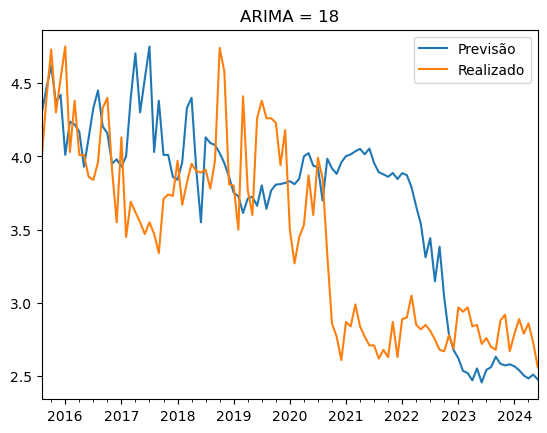

In [75]:
avaliacao[avaliacao["Horizonte_prj"] == 18][["Previsão","Realizado"]].plot(title="ARIMA = 18")